In [12]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
import pickle
#import imageio
#imageio.plugins.ffmpeg.download()
%matplotlib inline

In [13]:
CAMERA_CAL_PATH = 'camera_cal/calibration*.jpg'
CORNERS_X_Y = (9,6)
NPARTS = 8
CENTER_TOLERANCE = 60
window_size = 60

In [14]:
def camera_calibration(num_corners = CORNERS_X_Y):
    
    # http://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornersubpix
    # http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.0001)

    objp = np.zeros((num_corners[0]*num_corners[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:num_corners[0],0:num_corners[1]].T.reshape(-1,2)

    object_points = []
    image_points = []
    image_size = None
    images = glob.glob(CAMERA_CAL_PATH)
    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        image_size = gray.shape

        ret, corners = cv2.findChessboardCorners(gray, num_corners, None)

        if ret:
            object_points.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            image_points.append(corners2)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_size[::-1], None, None)

    return mtx, dist

mtx, dist = camera_calibration(CORNERS_X_Y)
print(mtx,dist)

[[  1.15693590e+03   0.00000000e+00   6.65949674e+02]
 [  0.00000000e+00   1.15213341e+03   3.88783826e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] [[ -2.37638395e-01  -8.53845052e-02  -7.90876672e-04  -1.15764260e-04
    1.05695685e-01]]


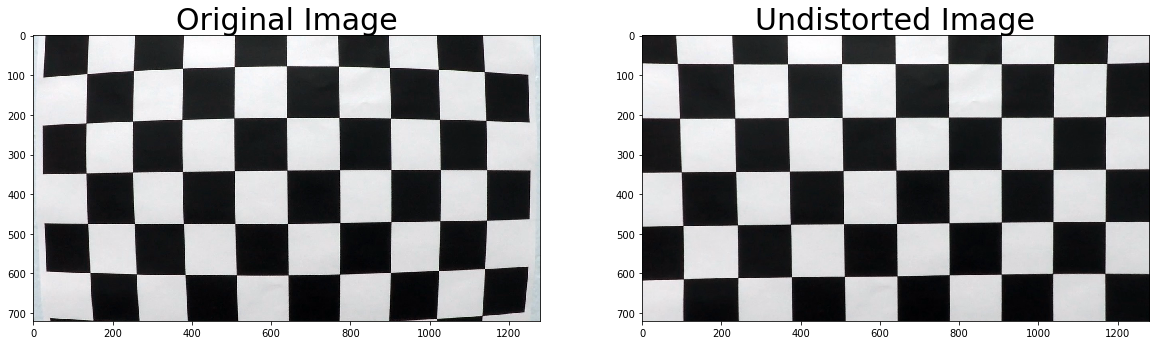

In [15]:

img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_cal.p", "wb" ) )
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

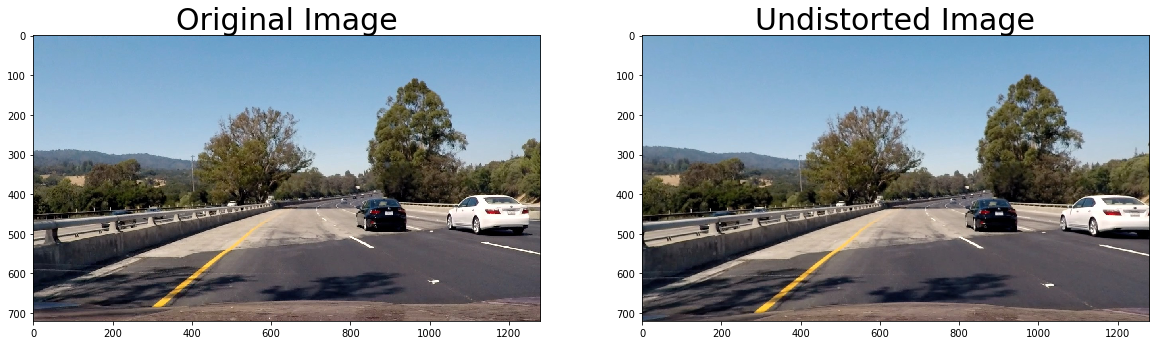

In [38]:
img2 = mpimg.imread('test_images/test4.jpg')
dst2 = cv2.undistort(img2, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst2)
ax2.set_title('Undistorted Image', fontsize=30)

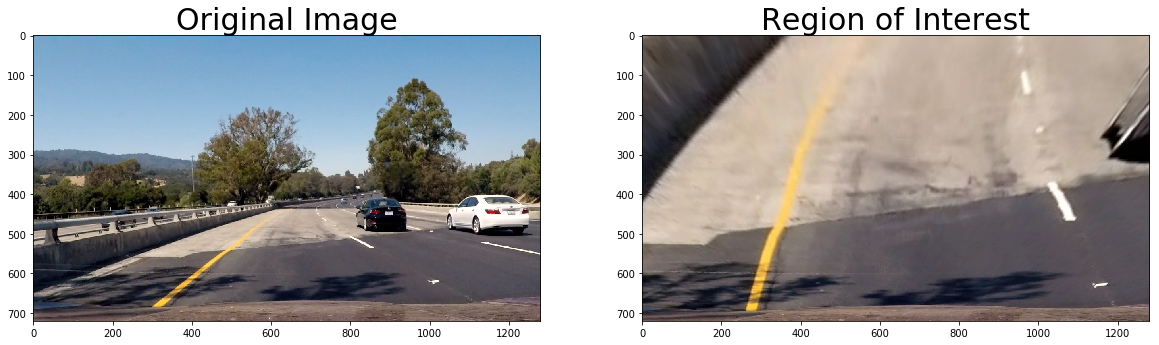

In [16]:
def undistort_image(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

def warp_image(image, src, dst, image_size):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_image = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped_image, M, Minv

def get_roi_transformed(image):
    image_size = image.shape
    roi_y_bottom = np.uint(image_size[0])
    roi_y_top = 450# np.uint(image_size[0]/1.5)
    roi_center_x = np.uint(image_size[1]/2)
    roi_x_top_left = roi_center_x - .25*roi_center_x
    roi_x_top_right = roi_center_x + .25*roi_center_x
    roi_x_bottom_left = 0
    roi_x_bottom_right = np.uint(image_size[1])
    # print(image_size,roi_y_bottom,roi_y_top,roi_center_x,roi_x_top_left,roi_x_top_right,roi_x_bottom_left,roi_x_bottom_right)
    src = np.float32([[roi_x_bottom_left,roi_y_bottom],[roi_x_bottom_right,roi_y_bottom],[roi_x_top_right,roi_y_top],[roi_x_top_left,roi_y_top]])
    dst = np.float32([[0,image_size[0]],[image_size[1],image_size[0]],[image_size[1],0],[0,0]])
    warped_image, M_warp, Minv_warp = warp_image(image,src,dst,(image_size[1],image_size[0]))
    return warped_image, M_warp, Minv_warp

image = mpimg.imread('test_images/test4.jpg')
roi_image, M, Minv = get_roi_transformed(image)
# Visualize ROI
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(roi_image)
ax2.set_title('Region of Interest', fontsize=30)

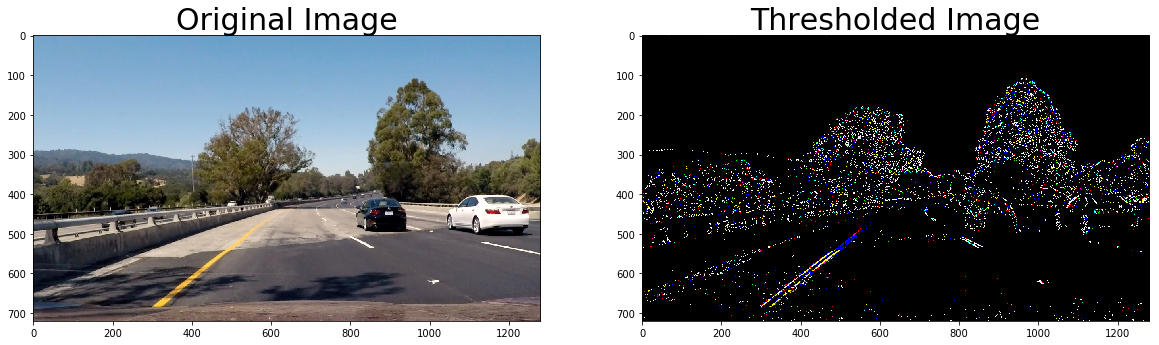

In [33]:
def abs_sobel_threshold(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient=='x':
        img_s = cv2.Sobel(image,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(image,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    binary_output = np.zeros_like(img_sobel)
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_threshold(image, sobel_kernel=3, thresh=(0, 255)):
    img_sx = cv2.Sobel(image,cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(image,cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = np.zeros_like(img_s)
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]= 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    img_sx = cv2.Sobel(image,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(image,cv2.CV_64F,0,1, ksize=sobel_kernel)
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    binary_output = np.zeros_like(grad_s)
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output

def combined_threshold(image):
    img_g_mag = mag_threshold(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_threshold(image,'x',5,(50,200))
    img_abs_y = abs_sobel_threshold(image,'y',5,(50,200))
    combined_threshold_result = np.zeros_like(img_d_mag)
    combined_threshold_result[((img_abs_x == 1) & (img_abs_y == 1)) | ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return combined_threshold_result

mag_binary = combined_threshold(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_binary)
ax2.set_title('Thresholded Image', fontsize=30)

In [18]:
def smooth_img(image, kernel=5):
    return cv2.GaussianBlur(image,(kernel,kernel),0)

def eval_poly(y, polynomial):
    return polynomial[0]*y**2 + polynomial[1]*y + polynomial[2]

def color_filter(hsv,low,high):
    return cv2.inRange(hsv, low, high)

def apply_color_filter(hsv,image,low,high):
    mask = cv2.inRange(hsv, low, high)
    return cv2.bitwise_and(image,image, mask= mask)

def get_curvature(polynomial,y):
    A = polynomial[0]
    B = polynomial[1]
    return (1+(2*A*y+B)**2)**1.5/2/A

def move_mean(array, n=3):
    moved = np.cumsum(array, dtype=float)
    moved[n:] = moved[n:] - moved[:-n]
    return moved[n - 1:] / n

def stack_arr(arr):
    return np.stack((arr, arr,arr), axis=2)

def draw_lines(image,pts,color):
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(image, (x1, y1), (x2, y2),color,50)

In [19]:
def first_mask(image,window_size):
    image = smooth_img(image,5)
    image_size = np.shape(image)
    mov_filtsize = image_size[1]/50.
    mean = np.mean(image[image_size[0]/2:,:],axis=0)
    mean = move_mean(mean,mov_filtsize)
    
    indexes = find_peaks_cwt(mean,[100], max_distances=[800])

    val_ind = np.array([mean[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    right_peak_idx = indexes[ind_sorted[0]]
    left_peak_idx = indexes[ind_sorted[1]]
    if right_peak_idx<left_peak_idx:
        ind_temp = right_peak_idx
        right_peak_idx = left_peak_idx
        left_peak_idx = ind_temp

    mask_L_i = np.zeros_like(image)
    mask_R_i = np.zeros_like(image)

    right_peak_idx_prev = right_peak_idx
    left_peak_idx_prev = left_peak_idx
    
    for i in range(NPARTS):
        y1 = image_size[0]-image_size[0]*i/NPARTS
        y2 = image_size[0]-image_size[0]*(i+1)/NPARTS
    
        mean_lane_y = np.mean(image[y2:y1,:],axis=0)
        mean_lane_y = move_mean(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            right_peak_idx = indexes[ind_sorted[0]]
            left_peak_idx = indexes[ind_sorted[1]]
            if right_peak_idx<left_peak_idx:
                ind_temp = right_peak_idx
                right_peak_idx = left_peak_idx
                left_peak_idx = ind_temp
            
        else:
        # If no pixels use previous
            if len(indexes)==1:
                if (np.abs(indexes[0]-right_peak_idx_prev)<np.abs(indexes[0]-left_peak_idx_prev)):
                    right_peak_idx = indexes[0]
                    left_peak_idx = left_peak_idx_prev
                else:
                    left_peak_idx = indexes[0]
                    right_peak_idx = right_peak_idx_prev
            else:
                left_peak_idx = left_peak_idx_prev
                right_peak_idx = right_peak_idx_prev
            
        # Center tolerance
        if np.abs(left_peak_idx-left_peak_idx_prev)>=CENTER_TOLERANCE:
            left_peak_idx = left_peak_idx_prev

        if np.abs(right_peak_idx-right_peak_idx_prev)>=CENTER_TOLERANCE:
            right_peak_idx = right_peak_idx_prev
            
        mask_L_i[y2:y1,left_peak_idx-window_size:left_peak_idx+window_size] = 1.
        mask_R_i[y2:y1,right_peak_idx-window_size:right_peak_idx+window_size] = 1.
        left_peak_idx_prev = left_peak_idx
        right_peak_idx_prev = right_peak_idx
        
    return mask_L_i, mask_R_i

def get_poly_mask(image, poly_fit, window_size):
    mask_poly = np.zeros_like(image)
    image_size = np.shape(image)
    poly_pts = []
    y_points = []
    for i in range(NPARTS):
        y1 = image_size[0]-image_size[0]*i/NPARTS
        y2 = image_size[0]-image_size[0]*(i+1)/NPARTS
        y = (y1+y2)/2
        y_points.append(y)
        poly = np.round(poly_fit[0]*y**2 + poly_fit[1]*y + poly_fit[2])
        poly_pts.append(poly)
        mask_poly[y2:y1, poly - window_size:poly + window_size] = 1.     
    return mask_poly, np.array(poly_pts), np.array(y_points)

In [20]:

def detect_lane_pipeline(image):
    global left_prev   
    global right_prev
    global right_lane_color_prev
    global left_lane_color_prev
    global mask_poly_right
    global mask_poly_left
    global first_frame
    
    image = undistort_image(image, mtx, dist)
    image = smooth_img(image, kernel=5)
    image_size = np.shape(image)
    color_right = (255,0,0)
    color_left = (255,0,0)

    # Get ROI
    warped, M_warp, Minv_warp = get_roi_transformed(image)
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    # Color filters ranges
    yellow_low  = np.array([0, 100, 100])
    yellow_high = np.array([50, 255, 255])
    white_low  = np.array([20, 0, 180])
    white_high = np.array([255, 80, 255])

    # get yellow and white masks 
    mask_yellow = color_filter(image_HSV,yellow_low,yellow_high)
    mask_white = color_filter(image_HSV,white_low,white_high)
    # Combined
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 
    
    # HLS conversion
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    # Apply Sobel filters on L and S channels.
    img_gs = image_HLS[:,:,1]
    img_abs_x = abs_sobel_threshold(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_threshold(img_gs,'y',5,(50,225))
    l_filtered = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel_threshold(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_threshold(img_gs,'y',5,(50,255))
    s_filtered = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    # Filers from LS Channels
    ls_filtered = cv2.bitwise_or(l_filtered,s_filtered)
    ls_filtered = smooth_img(ls_filtered,25)

    ls_filtered1 = np.zeros_like(ls_filtered)
    ls_filtered1[(mask_lane>=.5)|(ls_filtered>=.5)]=1
    
    # If this is first frame, get new mask.
    if first_frame == 0:
        ls_filtered1 = smooth_img(ls_filtered1,5)
        mask_poly_left, mask_poly_right = first_mask(ls_filtered1,40)
    
    # Apply mask to Sobel images
    left_lane = np.copy(ls_filtered1)
    left_lane = cv2.bitwise_and(ls_filtered1, ls_filtered1, mask = mask_poly_left)
    vals = np.argwhere(left_lane>.5)
    if len(vals)<5:
        left_fit = left_prev
        color_left = left_lane_color_prev
    else:
        all_x = vals.T[0]
        all_y = vals.T[1]
        # Compute polynomial fit for left
        left_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(left_lane,mask_yellow))>1000:
            color_left = (255,255,0)
            
    # Apply mask to Sobel images
    right_lane = np.copy(ls_filtered1)
    right_lane = cv2.bitwise_and(ls_filtered1, ls_filtered1, mask = mask_poly_right)
    vals = np.argwhere(right_lane>.5)
        
    if len(vals)<5:
        right_fit = right_prev
        color_right = right_lane_color_prev
    else:
        all_x = vals.T[0]
        all_y = vals.T[1]
        # Compute polynomial fit for right
        right_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(right_lane,mask_yellow))>1000:
            color_right = (255,255,0)
    
    # assign initial mask, and save coefficient values for next frame            
    if first_frame == 0:
        first_frame = 1
        right_prev = right_fit
        left_prev  = left_fit
    
    # Error check in both right and left
    error_right = np.sum((right_fit[0]-right_prev[0])**2)
    error_right = np.sqrt(error_right)
    if error_right>.0005:
        right_fit = right_prev
        color_right = right_lane_color_prev
    else:
        right_fit = .05*right_fit+.95*right_prev
        
    error_left = np.sum((left_fit[0]-left_prev[0])**2)
    error_left = np.sqrt(error_left)
    if error_left>.0005:
        left_fit =  left_prev
        color_left = left_lane_color_prev
    else:
        left_fit =  .05* left_fit+.95* left_prev
    
    # Compute Poly Mask
    mask_poly_left,left_pts,img_pts = get_poly_mask(ls_filtered1,left_fit,window_size)
    mask_poly_right,right_pts,img_pts = get_poly_mask(ls_filtered1,right_fit,window_size)
     
    # Compute lanes
    right_y = np.arange(11)*image_size[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    left_y = np.arange(11)*image_size[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(ls_filtered1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    points = np.hstack((pts_left, pts_right))
    
    # Compute intercepts
    left_bot = eval_poly(image_size[0],left_fit)
    right_bot = eval_poly(image_size[0],right_fit)
    
    # Compute center location
    val_center = (left_bot+right_bot)/2.0
    
    # Compute lane offset
    dist_offset = val_center - image_size[1]/2
    dist_offset = np.round(dist_offset/2.81362,1)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    if dist_offset>30:
        cv2.fillPoly(color_warp, np.int_([points]), (255, 0, 0))
    else:
        cv2.fillPoly(color_warp, np.int_([points]), (0, 255, 0))

    # Draw the lane onto the warped blank image    
    draw_lines(color_warp,np.int_(pts_left),color_left)
    draw_lines(color_warp,np.int_(pts_right),color_right)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    left_curve = get_curvature(left_fit,image_size[0]/2)
    right_curve = get_curvature(right_fit,image_size[0]/2)
    
    str_curv = 'Curvature R = ' + str(np.round(right_curve,2)) + ' | Curvature L = ' + str(np.round(left_curve,2)) 
    # Change color if distance is more than 30 cm
    font = cv2.FONT_HERSHEY_SIMPLEX    

    cv2.putText(result, str_curv, (100, 50), font, 1, (0,0,255), 2)
    cv2.putText(result, str_offset, (100, 100), font, 1, (0,0,255), 2)

    right_prev = right_fit
    left_prev  = left_fit
    right_lane_color_prev = color_right
    left_lane_color_prev = color_left
    
    return result

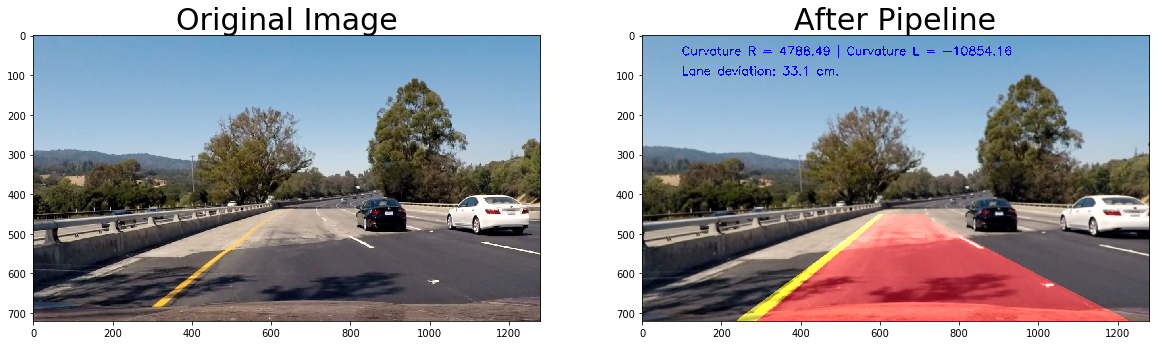

In [35]:
first_frame =0
result_pipe = detect_lane_pipeline(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result_pipe)
ax2.set_title('After Pipeline', fontsize=30)

In [23]:
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_final.mp4");
white_clip = clip1.fl_image(detect_lane_pipeline)
%time white_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:25<00:00,  4.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 25s
